<a href="https://colab.research.google.com/github/ved1beta/kaggle_pr_compition/blob/main/movieReccom_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [4]:
path = untar_data(URLs.ML_100k)

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
last_skywalker = np.array([0.98,0.9,-0.9])

In [7]:
user1 = np.array([0.9,0.8,-0.6])

In [8]:
(user1*last_skywalker).sum()

2.1420000000000003

In [9]:
(user1@last_skywalker)

2.1420000000000003

In [10]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [11]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [12]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,201,Amityville 3-D (1983),1
1,268,Wallace & Gromit: The Best of Aardman Animation (1996),5
2,648,Tales from the Crypt Presents: Bordello of Blood (1996),2
3,6,Wings of Desire (1987),4
4,903,Seven (Se7en) (1995),2
5,493,Apocalypse Now (1979),4
6,363,Rosencrantz and Guildenstern Are Dead (1990),4
7,606,Jerry Maguire (1996),4
8,747,Batman (1989),5
9,487,Evita (1996),2


In [13]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)



In [14]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t()

tensor([[-1.0827, -0.5195, -1.2804,  ...,  0.8009,  0.3354,  2.4054],
        [ 0.2138,  0.7613,  0.0705,  ..., -0.4734, -0.8262, -0.2156],
        [ 0.9310, -0.4365,  0.6489,  ..., -0.8962, -0.1541, -1.4126],
        [-0.2739,  0.1365, -1.2110,  ..., -0.7348,  0.4699, -0.2467],
        [-0.4359,  1.3300,  1.8266,  ..., -0.0246,  0.4873,  1.0571]])

In [15]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [16]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [17]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [19]:
x,y = dls.one_batch()
y.shape

torch.Size([64, 1])

In [21]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [24]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.345223,1.348054,00:11
1,1.034753,1.104441,00:10
2,0.893290,1.006152,00:10
3,0.810303,0.920107,00:10
4,0.775460,0.901163,00:09


In [27]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [28]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [29]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.887433,0.967378,00:11
1,0.651143,0.906181,00:11
2,0.512738,0.887207,00:11
3,0.443768,0.871301,00:10
4,0.435496,0.867597,00:15


In [31]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]


['Children of the Corn: The Gathering (1996)',
 'Bio-Dome (1996)',
 'Solo (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Crow: City of Angels, The (1996)']

In [32]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)']

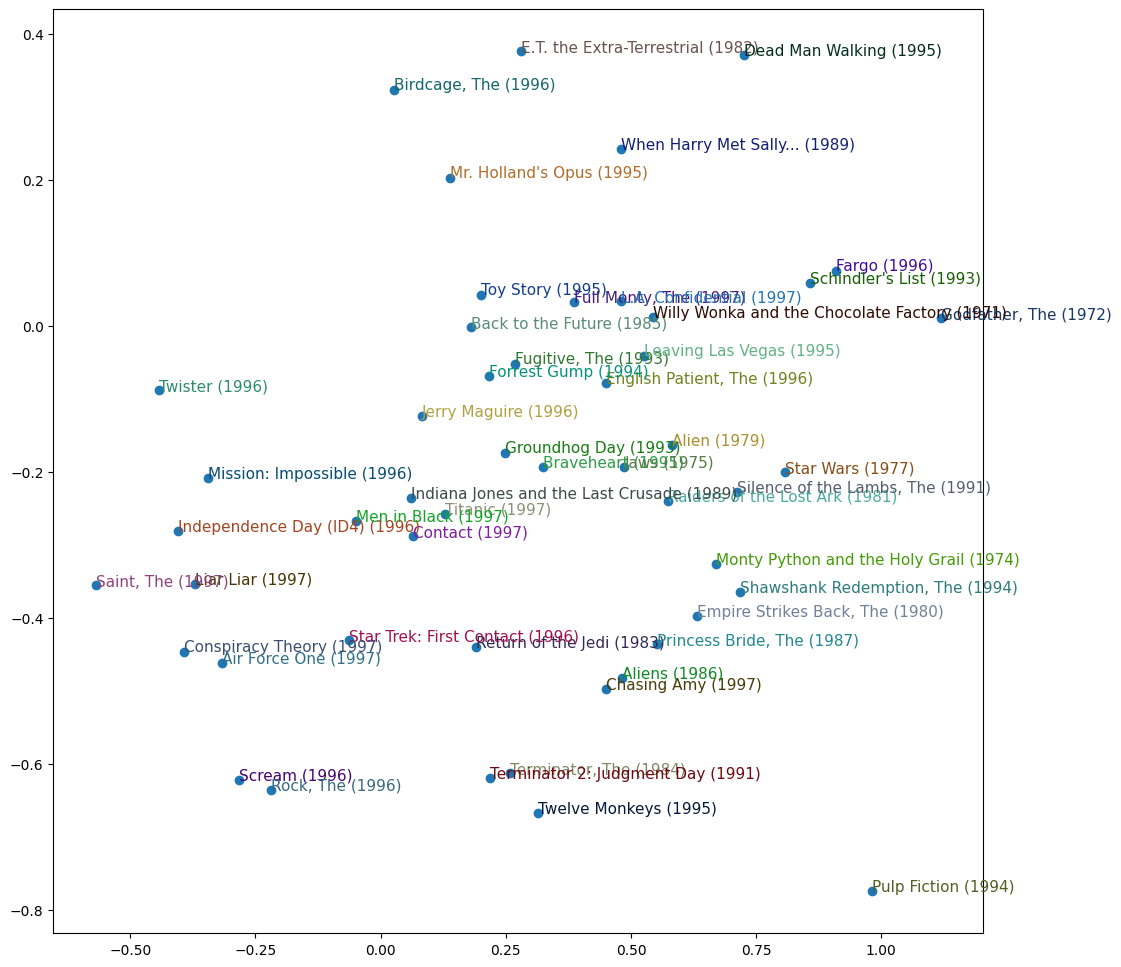

In [33]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [34]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

In [35]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [36]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Cyrano de Bergerac (1990)',
 'You So Crazy (1994)',
 'Rainmaker, The (1997)',
 'Hackers (1995)',
 'G.I. Jane (1997)']

In [37]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Days of Thunder (1990)'